## Create synthetic data to test out methods on

Two examples: The first one is completely from scratch, building up with different variables. 

The second example is based on the statistics from the EC dataset.

                     temperature   humidity  wind_speed  solar_radiation  \
2023-09-01 00:00:00    11.416146  62.875844    4.564386        25.483364   
2023-09-01 00:30:00    15.442129  78.283086    8.009892       143.950219   
2023-09-01 01:00:00    10.840930  75.775095    5.809148        96.592458   
2023-09-01 01:30:00    14.578743  64.375637    1.325149       -39.028762   
2023-09-01 02:00:00    10.275692  72.417634    1.861157        93.218869   

                     precipitation  latent_heat  
2023-09-01 00:00:00       1.619723    36.456110  
2023-09-01 00:30:00       0.931589    68.060323  
2023-09-01 01:00:00      -0.224453    56.662050  
2023-09-01 01:30:00       2.051440    23.673222  
2023-09-01 02:00:00       1.200567    54.451871  
        temperature      humidity    wind_speed  solar_radiation  \
count  17521.000000  17521.000000  17521.000000     17521.000000   
mean      19.990216     59.950410      5.007355       141.830481   
std        7.770474     14.100124      

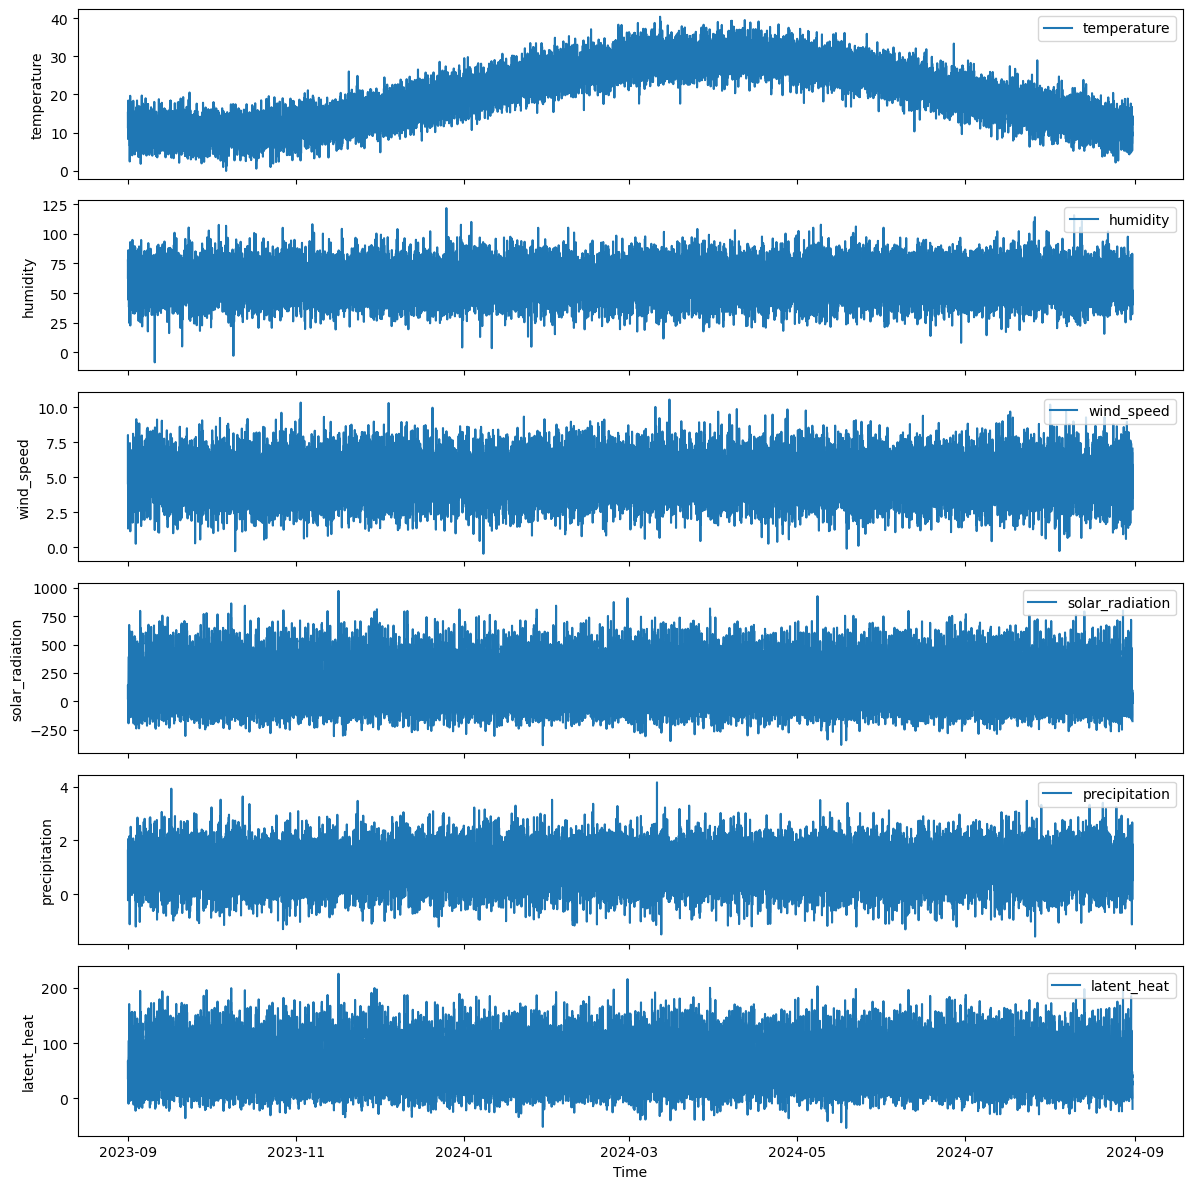

In [ ]:
import numpy as np
import pandas as pd

# Define time period and frequency
time_period = pd.date_range(start='2023-09-01', end='2024-08-31', freq='30min')
num_samples = len(time_period)


# Define feature distributions with adjustable noise
feature_means = {
    'temperature': 20,  # Mean temperature in degrees Celsius
    'humidity': 60,    # Mean relative humidity in %
    'wind_speed': 5,   # Mean wind speed in m/s
    'solar_radiation': 450,  # Mean solar radiation in W/m^2
    'precipitation': 1  # Mean precipitation in mm
}
feature_stds = {
    'temperature': 2,   # Std deviation for temperature
    'humidity': 10,     # Std deviation for humidity
    'wind_speed': 1,    # Std deviation for wind speed
    'solar_radiation': 100,    # Std deviation for solar radiation
    'precipitation': 0.5  # Std deviation for precipitation
}

# Generate features based on monthly means and additional noise
features = {}
for feature in feature_means:
    base = np.random.normal(loc=feature_means[feature], scale=feature_stds[feature], size=num_samples)
    seasonal_pattern = 10 * np.sin(2 * np.pi * time_period.dayofyear / 365)
    diurnal_pattern = 2 * np.sin(2 * np.pi * time_period.hour / 24)
    
    if feature == 'temperature':
        features[feature] = base + seasonal_pattern + diurnal_pattern
    elif feature == 'solar_radiation':
        features[feature] = base * np.maximum(0, np.sin(2 * np.pi * (time_period.hour - 6) / 24))
    else:
        features[feature] = base

features_df = pd.DataFrame(features, index=time_period)

# Add noise term to the features
for feature in features:
    noise = np.random.normal(0, feature_stds[feature], num_samples)
    features_df[feature] += noise

# Generate the target variable (latent heat) with additional noise term
noise = np.random.normal(0, 1, num_samples)
latent_heat_noise = 0.5  # Adjustable noise term for latent heat
latent_heat = 0. * features_df['temperature'] + 0.5 * features_df['humidity'] + 0.2 * features_df['solar_radiation'] + latent_heat_noise * noise
features_df['latent_heat'] = latent_heat

# Validate synthetic data
print(features_df.head())
print(features_df.describe())

# Uncomment if you want to save the synthetic dataset
# features_df.to_csv('../data/synthetic_dataset_no_original_data.csv', index=True)
# print('Synthetic dataset created successfully!')

# Plot for visual inspection
import matplotlib.pyplot as plt

num_features = len(features_df.columns)

# Create subplots
fig, axs = plt.subplots(num_features, figsize=(12, 2*num_features), sharex=True)

# Loop through each column and plot
for i, column in enumerate(features_df.columns):
    axs[i].plot(features_df.index, features_df[column], label=column)
    axs[i].set_ylabel(column)
    axs[i].legend(loc='upper right')

# Set the common x-label
plt.xlabel('Time')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()



ValueError: Cannot take a larger sample than population when 'replace=False'

Second example: Building synthetic data based on observaions statistics.

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope

# Load your existing dataset
existing_data = pd.read_csv("../data/Tuddal_data.csv", index_col=0, na_values=np.nan)

# Extract key statistics
column_names = existing_data.columns
mean = existing_data.mean()
std_dev = existing_data.std()

# Specify time period for synthetic data
time_period = pd.date_range(start='2023-01-01', end='2023-12-31', freq='H')

# Generate random data
synthetic_data = np.random.normal(loc=mean, scale=std_dev, size=(len(time_period), len(column_names)))
synthetic_data = np.clip(synthetic_data, a_min=0, a_max=None)

# Create DataFrame with time indices
synthetic_df = pd.DataFrame(synthetic_data, columns=column_names, index=time_period)

# Adding a daily oscillation to mimic diurnal patterns
daily_pattern = 10 * np.sin(2 * np.pi * synthetic_df.index.hour / 24)
for col in column_names:
    synthetic_df[col] += daily_pattern

# Standardize and remove outliers
scaler = StandardScaler()
envelope = EllipticEnvelope()
scaled_synthetic_data = scaler.fit_transform(synthetic_df)
envelope.fit(scaled_synthetic_data)
outlier_pred = envelope.predict(scaled_synthetic_data)
synthetic_df = synthetic_df[outlier_pred == 1]

# Save the synthetic dataset
#synthetic_df.to_csv('synthetic_dataset.csv', index=True)
#print('Synthetic dataset created successfully!')


/tmp/ipykernel_6966/68723594.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_period = pd.date_range(start='2023-01-01', end='2023-12-31', freq='H')
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/sklearn/covariance/_robust_covariance.py:748: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-313.291290295420822 > -313.577813739529006). You may want to try with a higher value of support_fraction (current value: 0.505).
  warnings.warn(
/home/mlahlbac/anaconda3/envs/geoscience_course/lib/python3.12/site-packages/sklearn/covariance/_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > l

                     temperature   humidity  wind_speed  precipitation  \
2023-09-01 00:00:00    13.162611  56.580957    5.654740       0.772917   
2023-09-01 00:30:00    12.689187  70.916846    5.455551       0.837536   
2023-09-01 01:00:00    15.775091  60.576102    4.166997       0.512768   
2023-09-01 01:30:00     9.333148  60.436937    4.705904       0.436482   
2023-09-01 02:00:00    12.389752  69.070430    4.947623       0.559486   

                     solar_radiation  latent_heat  
2023-09-01 00:00:00              0.0    38.725826  
2023-09-01 00:30:00              0.0    46.751960  
2023-09-01 01:00:00              0.0    43.169448  
2023-09-01 01:30:00              0.0    37.883540  
2023-09-01 02:00:00              0.0    45.106447  
        temperature      humidity    wind_speed  precipitation  \
count  17521.000000  17521.000000  17521.000000   17521.000000   
mean      20.321558     60.003859      5.028101       0.033832   
std        7.822459     14.010763      1.4145

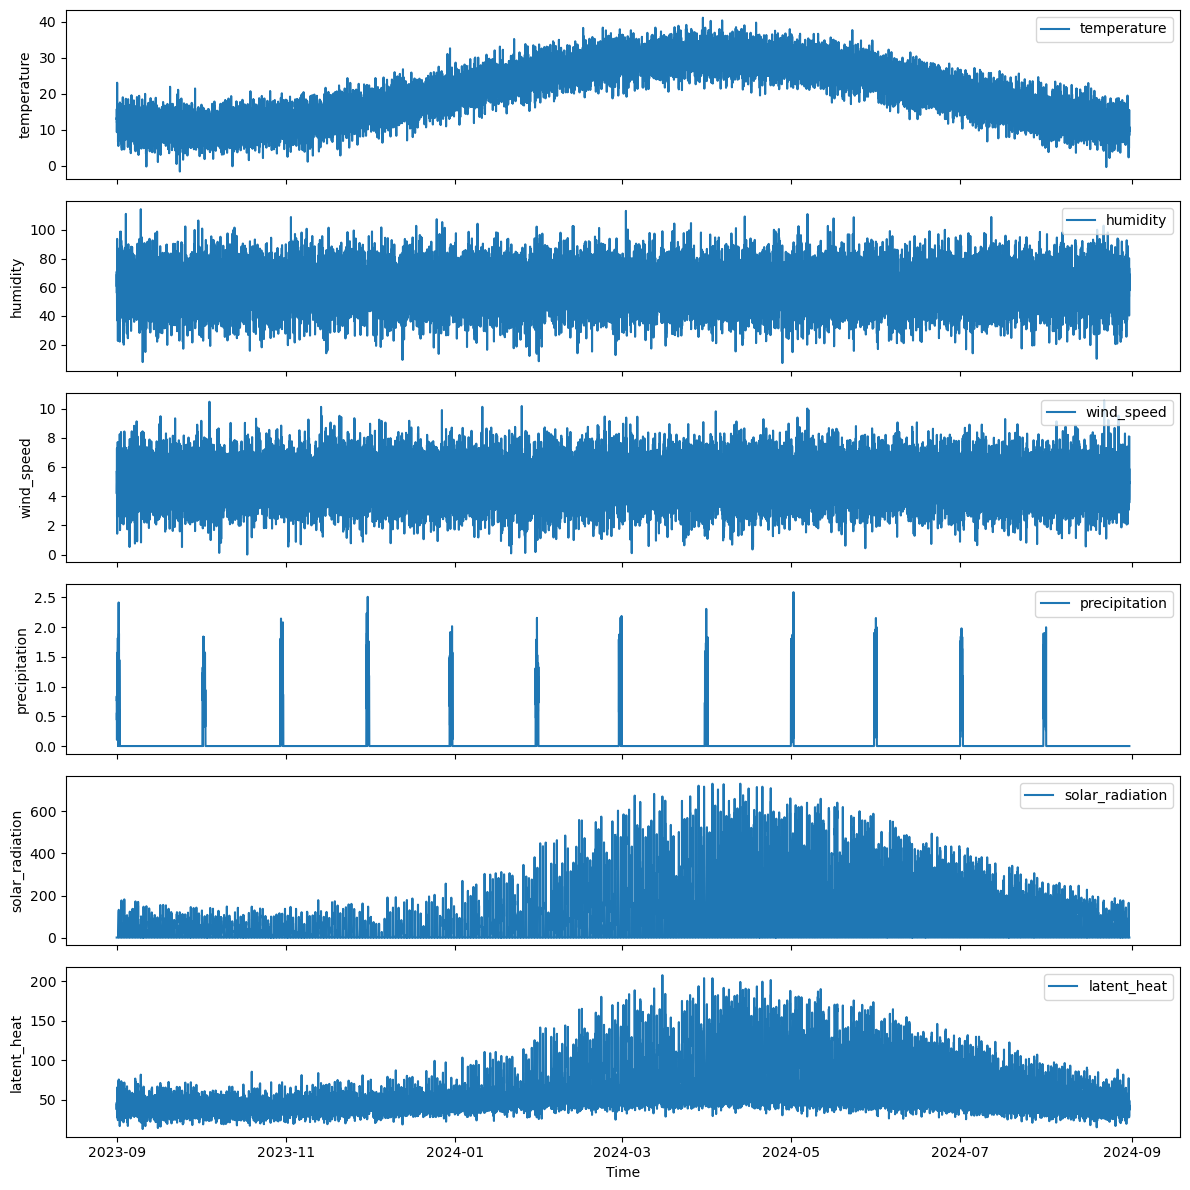

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# User-defined parameters
params = {
    'latitude': 60,
    'start_date': '2023-09-01',
    'end_date': '2024-08-31',
    'frequency': '30min',
    'feature_means': {
        'temperature': 20,  # Mean temperature in degrees Celsius
        'humidity': 60,  # Mean relative humidity in %
        'wind_speed': 5,  # Mean wind speed in m/s
        'precipitation': 1  # Mean precipitation in mm
    },
    'feature_stds': {
        'temperature': 2,  # Std deviation for temperature
        'humidity': 10,  # Std deviation for humidity
        'wind_speed': 1,  # Std deviation for wind speed
        'precipitation': 0.5  # Std deviation for precipitation
    },
    'average_rainy_days_per_month': [10, 8, 10, 12, 15, 18, 20, 18, 15, 12, 10, 12],  # Average rainy days per month
    'rain_transition_probability': 0.7,  # Probability that a rainy day will be followed by another rainy day
    'seasonal_amplitude': 10,
    'diurnal_amplitude': 2,
    'latent_heat_noise': 0.5,
}

# Define functions
def solar_declination(day_of_year):
    return 23.44 * np.sin(np.radians(360 / 365.24 * (day_of_year - 81)))

def day_length(day_of_year, latitude):
    decl = solar_declination(day_of_year)
    latitude_rad = np.radians(latitude)
    decl_rad = np.radians(decl)
    cos_hour_angle = -np.tan(latitude_rad) * np.tan(decl_rad)
    hour_angle = np.arccos(np.clip(cos_hour_angle, -1, 1))
    day_length_hours = 2 * np.degrees(hour_angle) / 15
    return day_length_hours

def generate_rainy_days(num_days, avg_rainy_days, transition_probability):
    rain_days = np.zeros(num_days)
    actual_rainy_days = min(num_days, avg_rainy_days)
    initial_rain_days = np.random.choice(num_days, actual_rainy_days, replace=False)
    
    for i in initial_rain_days:
        rain_days[i] = 1
        j = i + 1
        while j < num_days and np.random.rand() < transition_probability:
            rain_days[j] = 1
            j += 1

    return rain_days

# Define time period and frequency
time_period = pd.date_range(start=params['start_date'], end=params['end_date'], freq=params['frequency'])
num_samples = len(time_period)
num_days = len(pd.date_range(start=params['start_date'], end=params['end_date'], freq='D'))

# Generate monthly rainy days
rainy_days = np.zeros(num_days)
for month in range(1, 13):
    days_in_month = len(pd.date_range(start=f'2023-{month:02d}-01', end=f'2023-{month:02d}-01', freq='D') + pd.offsets.MonthEnd())
    monthly_rainy_days = generate_rainy_days(days_in_month, params['average_rainy_days_per_month'][month-1], params['rain_transition_probability'])
    start_day = pd.date_range(start=f'2023-{month:02d}-01', end=f'2023-12-31', freq='D').dayofyear[0] - 1
    rainy_days[start_day:start_day+days_in_month] = monthly_rainy_days

rainy_hours = np.repeat(rainy_days, 48)[:num_samples]  # 48 periods per day for half-hourly data

# Generate features based on user-defined means, stds, and additional noise
features = {}
for feature in params['feature_means']:
    base = np.random.normal(loc=params['feature_means'][feature], scale=params['feature_stds'][feature], size=num_samples)
    seasonal_pattern = params['seasonal_amplitude'] * np.sin(2 * np.pi * time_period.dayofyear / 365)
    diurnal_pattern = params['diurnal_amplitude'] * np.sin(2 * np.pi * time_period.hour / 24)

    if feature == 'temperature':
        features[feature] = base + seasonal_pattern + diurnal_pattern
    else:
        features[feature] = base

# Solar radiation and cloudiness factor
latitude = params['latitude']
solar_radiation = np.zeros(num_samples)
cloudiness_factor = np.random.uniform(low=0, high=1, size=num_samples)  # Random cloudiness factor

for i in range(num_samples):
    day_of_year = time_period[i].dayofyear
    hour_of_day = time_period[i].hour + time_period[i].minute / 60.0
    day_length_hours = day_length(day_of_year, latitude)
    max_radiation = 450 + 300 * np.sin(2 * np.pi * (day_of_year / 365))  # Adjust according to seasonality
    
    if hour_of_day < (24 - day_length_hours) / 2 or hour_of_day > 24 - (24 - day_length_hours) / 2:
        radiation = 0  # No radiation outside of daylight hours
    else:
        hour_angle = (hour_of_day - 12) * 2 * np.pi / 24  # Convert time to hour angle in radians
        effective_cloudiness = 1 if rainy_hours[i] == 1 else cloudiness_factor[i]
        reduction_factor = 0.7 if effective_cloudiness == 1 else 1 - effective_cloudiness
        radiation = max_radiation * max(0, np.sin(hour_angle)) * reduction_factor
    
    solar_radiation[i] = radiation

features['solar_radiation'] = solar_radiation
features_df = pd.DataFrame(features, index=time_period)

# Apply cloudiness and rain impact on temperature
temperature_adjustment = np.zeros(num_samples)
for i in range(num_samples):
    hour_of_day = time_period[i].hour
    effective_cloudiness = 1 if rainy_hours[i] == 1 else cloudiness_factor[i]
        
    # Temperature adjustment based on cloudiness and rain
    if effective_cloudiness > 0.5:  # Consider it cloudy if effective_cloudiness is greater than 0.5
        if hour_of_day >= 6 and hour_of_day <= 18:  # Cloudy during daytime
            if time_period[i].month in [6, 7, 8]:  # Summer months
                temperature_adjustment[i] = -2 * effective_cloudiness
            else:  # Other months
                temperature_adjustment[i] = 1 * effective_cloudiness
        else:  # Cloudy during nighttime
            temperature_adjustment[i] = 1.5 * effective_cloudiness
    
features_df['temperature'] += temperature_adjustment

# Apply rainy day impact on precipitation
precipitation_adjustment = np.zeros(num_samples)
for i in range(num_samples):
    if rainy_hours[i] == 1:
        precipitation_adjustment[i] = np.random.normal(loc=params['feature_means']['precipitation'], scale=params['feature_stds']['precipitation'])

features_df['precipitation'] = precipitation_adjustment

# Add noise term to the other features
for feature in features:
    if feature not in ('precipitation', 'solar_radiation'):
        noise = np.random.normal(0, params['feature_stds'].get(feature, 1), num_samples)
        features_df[feature] += noise

# Clip values to ensure they do not go below zero
features_df['precipitation'] = np.clip(features_df['precipitation'], 0, None)
features_df['humidity'] = np.clip(features_df['humidity'], 0, None)
features_df['wind_speed'] = np.clip(features_df['wind_speed'], 0, None)

# Generate the target variable (latent heat) with additional noise term
noise = np.random.normal(0, 1, num_samples)
latent_heat = 0.8 * features_df['temperature'] + 0.5 * features_df['humidity'] + 0.2 * features_df['solar_radiation'] + params['latent_heat_noise'] * noise
features_df['latent_heat'] = latent_heat

# Validate synthetic data
print(features_df.head())
print(features_df.describe())

# Uncomment if you want to save the synthetic dataset
# features_df.to_csv('synthetic_dataset_with_rainy_days.csv', index=True)
# print('Synthetic dataset created successfully!')

# Plot for visual inspection
num_features = len(features_df.columns)

# Create subplots
fig, axs = plt.subplots(num_features, figsize=(12, 2*num_features), sharex=True)

# Loop through each column and plot
for i, column in enumerate(features_df.columns):
    axs[i].plot(features_df.index, features_df[column], label=column)
    axs[i].set_ylabel(column)
    axs[i].legend(loc='upper right')

# Set the common x-label
plt.xlabel('Time')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
